# Diplomatura en ciencia de datos, aprendizaje automático y sus aplicaciones - Edición 2023 - FAMAF (UNC)

## Aprendizaje por refuerzos

### Trabajo práctico entregable 2/2 (materia completa)

**Estudiante:**
- [Chevallier-Boutell, Ignacio José.](https://www.linkedin.com/in/nachocheva/)

**Docentes:**
- Palombarini, Jorge (Mercado Libre).
- Barsce, Juan Cruz (Mercado Libre).

---

## Librerías

In [1]:
from typing import Callable, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium import spaces

import time

Para ver los videos de las ejecuciones hay que tener instalado ffmpeg (`apt-get install ffmpeg`).

---
# Ejercicio 1

Crear un entorno propio y entrenar agentes de RL en el mismo, utilizando diferentes algoritmos.

## Cheva's Odyssey: reglas del juego

El mapa del juego consiste en una grilla 6x6, como se muestra a continuación. Al comenzar un episodio, el agente se ubica en la posición $S$ (elemento [5, 5]) y debe llegar hasta $G$ (elemento [0, 2]) para terminar dicho episodio. El agente debe realizar tantos movimientos como sean necesarios para llegar a la meta y finalizar el episodio.

|J|A|G|A|~|~|
|-|-|-|-|-|-|
|~|A|A|A|~|~|
|~|~|~|~|~|~|
|~|~|~|~|~|~|
|A|A|~|~|~|~|
|P|A|~|~|~|S|

El espacio de estados $\mathcal{S}$ tiene 36 elementos. Para calcular el valor del estado asociado a cada elemento del mapa debemos calcular
    $$\text{Fila Actual} \times \text{Número de Columnas} + \text{Columna Actual}$$

donde debemos contar desde 0. De esta manera, el estado inicial $S$ es el estado 35 y el estado terminal $G$ es el estado 2.

El espacio de acciones $\mathcal{A}$ tiene 4 elementos para todos los estados que no están en el borde del mapa:
- 0 $\Rightarrow$ Se mueve hacia arriba.
- 1 $\Rightarrow$ Se mueve hacia la derecha.
- 2 $\Rightarrow$ Se mueve hacia abajo.
- 3 $\Rightarrow$ Se mueve hacia la izquierda.

Para los estados que están en los bordes, sólo se puede elegir entre 2 acciones si están en los vértices o entre 3 si están en las aristas, según corresponda. Observamos que se cumple que $\mathcal{A}, \mathcal{S} \in \mathbb{N}$.

Además de la salida $S$ y la meta $G$, tenemos otros elementos en el mapa. Los elementos vacíos (~) representan pasto, mientras que los elementos con $A$ son agua. El elemento $J$ es un jetpack y el elemento $P$ representa un premio extra. A partir de esto, la función de recompensa es tal que el agente recibe:
- $-1$ cuando ingresa en a un elemento con pasto o cuando busca el jetpack o el premio extra. Sus efectos no se pierden, pero tampoco se acumulan.
- $-8$ cuando ingresa en a un elemento con agua. En caso de contar con el jetpack, el costo por pasar por el agua se reduce a $-2$.
- $+0$ si alcanza la meta sin el premio extra y $+24$ cuando la alcanza con el premio extra.

Hay principalmente 5 caminos relevantes:
- **SG:** Ir directo a la meta requiere 8 pasos temporales, otorgando -14 puntos.
- **SJG:** Buscar el jetpack e ir a la meta requiere 12 pasos temporales, otorgando -12 puntos.
- **SPG:** Buscar el premio extra e ir a la meta requiere 12 pasos temporales, otorgando -8 puntos.
- **SPJG:** Buscar el premio extra, luego el jetpack e ir a la meta requiere 12 pasos temporales, otorgando -2 puntos.
- **SJPG:** Buscar el jetpack, luego el premio extra e ir a la meta requiere 22 pasos temporales, otorgando 0 puntos (puntuación máxima).

## Creación del agente

In [2]:
class ChevasOdyssey(gym.Env):
    # Tipo de renderizado posible, además de None.
    metadata = {"render.modes": ["console"]}

    # Definimos los valores de las acciones
    UP = 0
    RIGHT = 1
    DOWN = 2
    LEFT = 3

    # Efectos del Jetpack y el premio
    JETPACK = 1
    PREMIO = 0

    def __init__(self):
        super(ChevasOdyssey, self).__init__()

        # Tamaño del mapa
        self.grid_shape = (6, 6)

        # Espacio de acciones
        self.action_space = spaces.Discrete(4)

        # Espacio de estados
        self.observation_space = spaces.Discrete(36)

        # Inicializamos en agente en la salida
        self.agent_pos = 35

        # Ubicamos el jetpack
        self.jetpack_pos = 0

        # Ubicamos el premio extra
        self.extra_pos = 30

        # Ubicamos la meta
        self.goal_pos = 2

        # Ubicamos el agua
        self.water_pos = [1, 3, 7, 8, 9, 24, 25, 31]

    def reset(self, seed=None) -> Tuple[np.array, dict]:
        """
        Reinicia el ambiente y devuelve la observación inicial
        """

        # Inicializamos en agente en el punto de partida
        self.agent_pos = 35

        self.JETPACK = 1
        
        self.PREMIO = 0

        return (self.agent_pos, {})

    def step(self, action):
        if action == self.UP:
            self.agent_pos -= 6
        elif action == self.RIGHT:
            self.agent_pos += 1
        elif action == self.DOWN:
            self.agent_pos += 6
        elif action == self.LEFT:
            self.agent_pos -= 1
        else:
            raise ValueError(
                f"Se recibió una acción inválida={action} que no es parte del\
                    espacio de acciones"
            )

        # Evitamos que el agente se salga de los límites de la grilla
        self.agent_pos = np.clip(self.agent_pos, 0, 36)

        # Consigue el jetpack
        if self.agent_pos == self.jetpack_pos:
            self.JETPACK = 4

        # Consigue el premio extra
        if self.agent_pos == self.extra_pos:
            self.PREMIO = 24

        # Llegada a la meta
        terminated = bool(self.agent_pos == self.goal_pos)
        truncated = False

        # Asignación de recompensa
        if self.agent_pos == self.goal_pos:
            reward = self.PREMIO
        elif self.agent_pos in  self.water_pos:
            reward = -8 / self.JETPACK
        else:
            reward = -1

        # Información adicional
        info = {}

        return (
            self.agent_pos,
            reward,
            terminated,
            truncated,
            info,
        )

    def render(self, mode="console"):
        print('Not implemented yet.')

    def close(self):
        pass

In [3]:
# validamos que el ambiente cumpla con la interfaz de gym
from stable_baselines3.common.env_checker import check_env

env = ChevasOdyssey()
# Si el entorno no cumple con la interfaz, se lanzará una excepción
check_env(env, warn=True)

AssertionError: The observation returned by the `step()` method does not match the given observation space Discrete(36)

In [4]:
def epGreedy(
    state: int,
    actions: range,
    q: dict,
    hyperparameters: dict,
    random_state: np.random.RandomState
) -> int:

    """
    Elije una acción de acuerdo a una política de exploración-explotación 
    épsilon-greedy.
    Args:
        state: estado actual del agente
        actions: lista de acciones posibles
        q: diccionario de valores de estado-acción
        hyperparameters: hiperparámetros del algoritmo de aprendizaje
        random_state: generador de números aleatorios
    """

    # Lista de valores q asociados a un estado-acción
    
    q_values = [q.get((state, a)) for a in actions]

    # Toma el valor máximo
    max_q = max(q_values)

    # Puede haber más de un valor máximo
    count = q_values.count(max_q)

    # Sortemaos un número aleatorio y comparamos con épsilon
    if random_state.uniform() < hyperparameters['epsilon']:
        # Exploramos, seleccionando una acción aleatoriamente
        return random_state.choice(actions)

    # Al no cumplirse la condición, explotamos
    elif count > 1:
        # Hay más de un valor máximo. Sorteamos alguno de ellos
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    
    else:
        # Hay un único valor máximo, eligiendo el correspondiente estado-acción
        i = q_values.index(max_q)

    return actions[i]

In [5]:
def SARSA_learning(
    state: int,
    action: int,
    reward: int,
    next_state: int,
    next_action: int,
    hyperparameters: dict,
    q: dict
) -> Tuple[int, int]:

    """
    Realiza una actualización según el algoritmo SARSA, para una transición de 
    estado dada.
    Args:
        state: estado actual del agente
        action: acción actual ejecutada por el agente
        reward: recompensa recibida al ejecutar la acción
        next_state: próximo estado del agente
        next_action: próxima acción del agente
        hyperparameters: hiperparámetros del algoritmo de aprendizaje
        q: diccionario de valores de estado-acción
    """

    # Actualizo el valor del estado-acción
    Target = reward + hyperparameters['gamma'] * q[(next_state, next_action)]
    TD_error = Target - q[(state, action)]
    q[(state, action)] += hyperparameters['alpha'] * TD_error

    # Actualizo el estado
    state = next_state

    # Actualizo la acción
    action = next_action

    return state, action

In [6]:
def run_SARSA(
    policy: Callable,
    hyperparameters: dict,
    episodes_to_run: int,
    env: gym.Env,
    actions: range,
    random_state: np.random.RandomState,
    max_iter: int
) -> Tuple[np.ndarray, np.ndarray, int, int, int, dict]:

    """
    Corre el algoritmo de RL, basado en SARSA.
    Args:
        policy: huerística de selección de acciones
        hyperparameters: hiperparámetros del algoritmo de aprendizaje
        episodes_to_run: cantidad de episodios a ejecutar
        env: entorno de Gymnasium
        actions: lista de acciones posibles
        random_state: generador de números aleatorios
        max_iter: cantidad máxima de pasos temporales
    """

    # Inicialización del diccionario de valores de estado-acción
    q = {}
    for s in range(37):
        for a in range(4):
            q[(s, a)] = 0.0

    # Registra la cantidad de pasos de cada episodio
    timesteps_of_episode = []

    # Registra el retorno de cada episodio
    return_of_episode = []

    # Casuísticas de finalización
    goal, drop, early = 0, 0, 0

    # Loop sobre los episodios
    for _ in range(episodes_to_run):
        # Instancea un nuevo agente en cada episodio
        # Fin del episodio: llegar a la salida o superar max_iter

        # Reinicia el entorno, obteniendo el estado inicial del mismo
        state, _ = env.reset()

        # Retorno del episodio
        episode_return = 0

        # Contador de pasos temporales
        t = 0

        # Flag de finalización de iteración actual
        done = False

        # Elige la primera acción a ejecutar
        action = policy(
            state, actions, q, hyperparameters, random_state)

        while not done:
            # El agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, terminated, truncated, _ = env.step(action)

            # Acumulamos recompensa
            episode_return += reward

            # Elige la nueva acción a ejecutar partiendo desde el nuevo estado
            next_action = policy(
                next_state, actions, q, hyperparameters, random_state)

            # Mecanismo de aprendizaje por TD con SARSA
            state, action = SARSA_learning(
                state, action, reward, next_state, next_action, hyperparameters, q)

            # Análisis de convergencia
            if terminated:
                # El agente alcanzó el objetivo
                goal += 1
                timesteps_of_episode = np.append(
                    timesteps_of_episode, [int(t + 1)])
                return_of_episode = np.append(return_of_episode, episode_return)
                done = True

            elif truncated:
                # El agente ejecutó una acción inválida
                drop += 1
                timesteps_of_episode = np.append(
                    timesteps_of_episode, [int(t + 1)])
                return_of_episode = np.append(return_of_episode, episode_return)
                done = True

            elif t >= max_iter:
                # Early stopping
                early += 1
                timesteps_of_episode = np.append(
                    timesteps_of_episode, [int(t + 1)])
                return_of_episode = np.append(return_of_episode, episode_return)
                done = True

            t += 1

    return timesteps_of_episode, return_of_episode, goal, drop, early, q

In [11]:
env = ChevasOdyssey()
actions = range(env.action_space.n)
policy = epGreedy

max_iter = 2000
Sw_eps = [100000]
Sw_a = [0.05]
Sw_g = [1]
Sw_e = [0.005]

for p_eps in Sw_eps:
    episodes_to_run = p_eps
    for p_a in Sw_a:
        for p_g in Sw_g:
            for p_e in Sw_e:
                hyperparameters = {
                    "alpha": p_a,
                    "gamma": p_g,
                    "epsilon": p_e,
                }

                random_state = np.random.RandomState(1994)

                start = time.time()
                ep_timesteps, ep_return, ep_goal, ep_drop, ep_early, q = run_SARSA(
                    policy,
                    hyperparameters,
                    episodes_to_run,
                    env,
                    actions,
                    random_state,
                    max_iter
                )
                WallTime = time.time() - start

                env.close()

                # Guardamos los resultados
                runType = f'SARSA-{policy.__name__}'
                runPar = f'its-{max_iter}_eps-{episodes_to_run}'
                runHPar = f'a-{hyperparameters["alpha"]}_g-{hyperparameters["gamma"]}_e-{hyperparameters["epsilon"]}'

                with open(f'Outputs/Lab2/{runType}_{runPar}_{runHPar}.csv', 'w') as f:
                    f.write('Goal\tDrop\tEarly\tTotal\n')
                    f.write(f'{ep_goal}\t{ep_drop}\t{ep_early}\t{episodes_to_run}\n')

                    f.write(f'Wall Time[s]\t{WallTime}\n')
                    
                    f.write('State\tAction\tQ-value\n')
                    for s in range(37):
                        for a in range(4):
                            f.write(f'{s}\t{a}\t{q[(s,a)]:.6f}\n')

                    f.write('Return\tTimeSteps\n')
                    for i in range(episodes_to_run):
                        f.write(f'{ep_return[i]:.0f}\t{ep_timesteps[i]:.0f}\n')

In [8]:
def mean_evol(Arr: np.ndarray) -> np.ndarray:
    """
    Suaviza la curva de aprendizaje o de recompensa.
    Args:
        Arr: array a suavizar
    """

    eps_val = np.linspace(1, len(Arr) + 1, len(Arr) + 1)
    cum_vals = np.cumsum(Arr)

    val_per_eps = [cum_vals[i] / eps_val[i] for i in range(len(cum_vals))]

    return np.array(val_per_eps)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


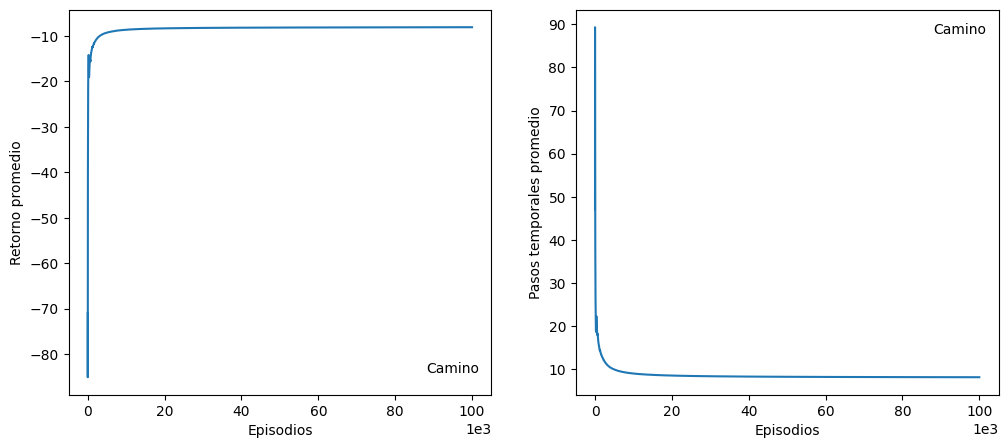

In [12]:
_, axs = plt.subplots(1, 2, figsize=(12, 5))

File = pd.read_csv(f'Outputs/Lab2/SARSA-epGreedy_its-2000_eps-100000_a-0.05_g-1_e-0.005.csv', header=None, sep='\t').iloc[153:, :2].to_numpy().astype(int)

axs[0].plot(mean_evol(File[:,0]))#, label=rf'$\gamma$ = {p_g}')
axs[1].plot(mean_evol(File[:,1]))#, label=rf'$\gamma$ = {p_g}')

# axs[0].set_ylim(-18, -12)
# axs[1].set_ylim(12, 18)

# axs[0].axhline(-13, color='red', linestyle=':', label='Óptimo')
# axs[0].axhline(-17, color='blue', linestyle=':', label='Seguro')

axs[0].set_xlabel('Episodios')
axs[1].set_xlabel('Episodios')

# axs[1].axhline(13, color='red', linestyle=':', label='Óptimo')
# axs[1].axhline(17, color='blue', linestyle=':', label='Seguro')

axs[0].ticklabel_format(style='sci', axis='x', scilimits=(3,3))
axs[1].ticklabel_format(style='sci', axis='x', scilimits=(3,3))

axs[0].set_ylabel('Retorno promedio')
axs[1].set_ylabel('Pasos temporales promedio')

axs[0].legend(loc='lower right', frameon=False, fancybox=True, title='Camino')
axs[1].legend(loc='upper right', frameon=False, fancybox=True, title='Camino')

plt.savefig('Outputs/Lab2/SARSA-epGreedy_its-2000_eps-100_a-0.05_g-1_e-0.005.png')